torch.Size([996, 4])
torch.Size([996, 1])
epoch:0, loss:0.05301207965730052
epoch:1, loss:0.047606803231725565
epoch:2, loss:0.04954005361191536
epoch:3, loss:0.05014432804953111
epoch:4, loss:0.04681708962705575
epoch:5, loss:0.048372222845883744
epoch:6, loss:0.046021297770111186
epoch:7, loss:0.047120213018436184
epoch:8, loss:0.050706054819257634
epoch:9, loss:0.04784841629627504


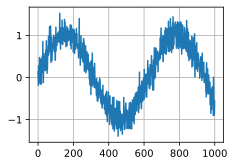

In [18]:
import d2l
%matplotlib inline

# models
import torch
from torch import nn
from d2l import plot


T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plot(x)

# generate feature-label
tau = 4
feature = torch.zeros((T-tau,tau))  # 996x4 -> 996 feature-label (feature size: 4 elements for 1D)

for i in range(tau):  # full feature in column as it quick then in cow
    feature[:,i] = x[i:T-tau+i]
print(feature.shape)
labels = x[tau:].reshape((-1,1)) # feature x[t-tau], x[t-tau+1], ..., x[t-tau+3] (tau = 4), label: x[t]
print(labels.shape)

batch_size = 16
n_train = 600

train_iter = d2l.load_array((feature[0:n_train],labels[0:n_train]),batch_size=batch_size,is_train=True)

def init_weitht(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(
        nn.Linear(4,50),nn.ReLU(),
        nn.Linear(50,1)
    )
    net.apply(init_weitht)
    return net
def train(net, train_iter, epochs, loss_function, lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for features, labels in train_iter:
            net.train()
            trainer.zero_grad()

            l = loss_function(net(features),labels)
            l.sum().backward()  # grad will be stored in every tensor
            trainer.step()
        print(f'epoch:{epoch}, loss:{d2l.accurancy_loss(net,train_iter,nn.MSELoss())}')

net = get_net()
loss_func = nn.MSELoss(reduction='none')
train(net,train_iter,10,loss_func,0.01)

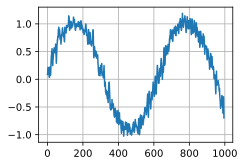

In [20]:
pre_result = net(feature)
plot(pre_result.reshape(-1,).detach().numpy())

In [1]:
# text pre-procession

In [43]:
# RNN
from d2l import torch as d2l
import torch
import math
from torch import nn
from torch.nn import functional as F

batch_size = 32
num_steps = 35
train_iter, vocab = d2l.load_data_time_machine(batch_size=batch_size,num_steps=num_steps)
for data,label in train_iter:
    print(data.shape,label.shape)
    y = label.T.reshape(-1)
    # print(y)
    # print(label)
    y.long()
    print(y.shape)

torch.Size([32, 35]) torch.Size([32, 35])
torch.Size([1120])
torch.Size([32, 35]) torch.Size([32, 35])
torch.Size([1120])
torch.Size([32, 35]) torch.Size([32, 35])
torch.Size([1120])
torch.Size([32, 35]) torch.Size([32, 35])
torch.Size([1120])
torch.Size([32, 35]) torch.Size([32, 35])
torch.Size([1120])
torch.Size([32, 35]) torch.Size([32, 35])
torch.Size([1120])
torch.Size([32, 35]) torch.Size([32, 35])
torch.Size([1120])
torch.Size([32, 35]) torch.Size([32, 35])
torch.Size([1120])


In [44]:

def get_params(vocab_size, num_hiddens, device):
    """
    construct params for RNN which has one hidden layer and one output layer
    :param vocab_size:
    :param num_hiddens:
    :param device:
    :return:
    """
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        # 标准正态分布
        return torch.randn(size = shape,device=device) * 0.01  # ??? what

    # one hidden layer
    # num_inputs x num_hidden -> attention: every hidden unite need all input_unit to multiply weight( height_num) as it's full connection layers
    # weight from x to h (hidden layer)
    W_xh = normal((num_inputs,num_hiddens))
    # weight from h_t-1 to h_t
    # num_hidden x num_hidden as the number of hidden units should be the same
    W_hh = normal((num_hiddens, num_hiddens))
    # n x d x d x h -> n x h
    # bias for hidden layer connection ( from t-1 to t)
    B_h = torch.zeros(num_hiddens, device=device)  # every hidden unit should have a bias for all sequence item or all elememts

    # output layer
    W_hq = normal((num_hiddens,num_outputs))
    B_q = torch.zeros(num_outputs,device=device)

    params = [W_xh,W_hh,B_h,W_hq,B_q]
    for param in params:
        param.requires_grad_(True)
    return params


def init_rnn_state(batch_size, num_hiddens, device):
    """
    return first hidden state as it has no pre-hidden-state to base on
    :param batch_size:
    :param num_hiddens:
    :param device:
    :return:
    """
    return (torch.zeros((batch_size,num_hiddens),device=device), )

def rnn(inputs, state, params):
    """
    to run rnn calculation
    # inputs的形状：(时间步数量，批量大小，词表大小)
    :param inputs:
    :param state:
    :param params:
    :return:
    """
    W_xh, W_hh, B_h, W_hq, B_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X,W_xh) + torch.mm(H,W_hh) + B_h)
        Y = torch.mm(H,W_hq) + B_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0), (H,)

class RNNModelScratch:
    def __init__(self,vocab_size, num_hiddens, device, get_params_func, init_state_func, forward_func):
        self.vocab_size, self.hiddens  =vocab_size, num_hiddens
        self.params = get_params_func(self.vocab_size,num_hiddens,device)
        self.init_state_func, self.forward_func = init_state_func,forward_func

    def __call__(self, X, state):
        """
        calculate
        :param X:
        :return:
        """
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)  # why use T, the dimension of data from iter is different from data input into net
        return self.forward_func(X,state,self.params)

    def begin_state(self,batch_size, device):
        return self.init_state_func(batch_size, self.hiddens ,device)

X = torch.arange(10).reshape((2, 5))
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, 'cuda:0', get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0]

def predict_ch8(prefix, num_preds, net, vocab, device):
    """
    RNN predic
    :param prefix:
    :param num_preds:
    :param net:
    :param vocab:
    :param device:
    :return:
    """
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]  # get index of char

    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape((1,1))  # get the last char of outputs as input
    for y in prefix[1:]: # warm up
        _, state = net(get_input(),state)
        outputs.append(vocab[y])
    # for y in prefix[1:]: # more warm up
    #     _, state = net(get_input(),state)
    for _ in range(num_preds): # prediction
        y, staet = net(get_input(), state)
        outputs.append(int(y.argmax(dim = 1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

# todo..
# I have understood code but have no time to implement again


'time traveller iiiiiiiiii'

time traveller came back and than at atsute thi garmothe of mank


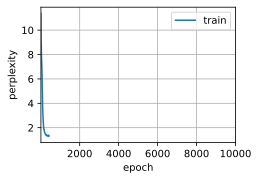

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# RNN net define
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab),num_hiddens) # len(vocab) is the input elements number which are generated by one_hot function; num_hiddens is the output number
state = torch.zeros((1,batch_size,num_hiddens))

X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)


#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

num_epochs, lr = 10000, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)